**1. IMPORTER LIBRAIRIES**

In [4]:
#!pip install -q transformers==4.31.0 tensorflow==2.12.0 sentencepiece
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Train_Test_Split
from sklearn.model_selection import train_test_split

# Camembert
import tensorflow as tf
import torch
import torchvision
import transformers
from transformers import CamembertTokenizer, TFCamembertForSequenceClassification
# from transformers import CamembertTokenizer, TFCamembertModel, CamembertForSequenceClassification

# CNN
import keras
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Activation
from tensorflow.keras.optimizers import Adam

# Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Performances
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Enregistrer le modèle
from sklearn import model_selection
import joblib

import warnings
warnings.filterwarnings('ignore')

**2. IMPORTER LE FICHIER**

In [5]:
df = pd.read_csv("2. Pre-processing & Feature engineering_1.csv")
df = df[['commentaires', 'notes']]
df = df[:1000] # Tester sur un échantillon de données
# Remplace les notes 1,2,3,4,5 par 0,1,2,3,4
df['notes'] = df['notes'].replace((1, 2, 3, 4, 5), (0, 1, 2, 3, 4))

# Target / Features
X = df['commentaires']
y = df['notes']

**3. PRE-PROCESSING**

In [6]:
### TOKENIZATION ###
# Initialisation du tokenizer de CamemBERT
tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=True)

commentaires = df['commentaires'].to_list()
# notes = df['notes'].to_list()

max_len = 100
# Tokenization : Convertir les phrases en tokens
input_ids  = [tokenizer.encode(phrases, add_special_tokens=True, max_length=max_len) for phrases in commentaires]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [7]:
### PADDING ###
input_ids = pad_sequences(input_ids, maxlen = max_len, dtype="long", truncating="post", padding="post")

In [8]:
### ATTENTION MASKS ###
attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [9]:
### DICHOTOMISATION ###
y = df['notes']
y = pd.get_dummies(y)
# Remplacer les valeur booléennes par des entiers
rep = {False: 0, True: 1}
y[[0, 1, 2, 3, 4]] = y[[0, 1, 2, 3, 4]].replace(to_replace = rep)
# Remplacement des colonnes avec le nom des classes
colnames = {0:'Cl1',1:'Cl2', 2:'Cl3',3:'Cl4',4:'Cl5'}
y = y.rename(columns=colnames)

**4. TRAIN_TEST_SPLIT**

In [10]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(input_ids,
                                                                    y,
                                                                    random_state=42,
                                                                    test_size=0.2)
### Vérification des shape ###
print ("X_train =", X_train.shape)
print ("y_train =", y_train.shape)
print ("X_test =", X_test.shape)
print ("y_test =", y_test.shape)

X_train = (800, 100)
y_train = (800, 5)
X_test = (200, 100)
y_test = (200, 5)


**5. MODELISATION**

In [11]:
### CONSTANTES ###
nb_class = y_train.shape[1]
batch_size = 64
epochs = 3

In [12]:
### CALLBACKS ###
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',
                                         min_delta = 1e-1,
                                         patience = 5,
                                         factor = 5e-2,
                                         cooldown = 2,
                                         verbose = 1)

early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 1e-3,
                               patience = 3,
                               verbose = 1,
                               restore_best_weights = True)

In [13]:
### IMPORTER LE MODELE CAMEMBERT ###
model = TFCamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=nb_class)

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFCamembertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFCamembertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
### COMPILATION ###
model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics=["accuracy"])

In [15]:
### ENTRAÎNEMENT DU MODELE ###
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    batch_size = batch_size,
                    epochs = epochs,
                    callbacks = [reduce_learning_rate, early_stopping])

Epoch 1/3


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
13/13 [==============================] - 1099s 76s/step - loss: 2.5548 - accuracy: 0.5138 - val_loss: 0.8865 - val_accuracy: 0.4450 - lr: 0.0010
Epoch 2/3
13/13 [==============================] - 954s 73s/step - loss: 2.7849 - accuracy: 0.4525 - val_loss: 0.7253 - val_accuracy: 0.4450 - lr: 0.0010
Epoch 3/3
13/13 [==============================] - 931s 72s/step - loss: 6.3264 - accuracy: 0.4550 - val_loss: 15.3928 - val_accuracy: 0.4450 - lr: 0.0010


**6. PERFORMANCES DU MODELE**

In [49]:
y_pred = model.predict(X_test)

y_pred_labels = np.argmax(y_pred.logits, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
print('Score modèle :', accuracy_score(y_test_labels, pred_labels))

print(classification_report(y_test_labels, y_pred_labels))

confusion_matrix = pd.crosstab(y_test_labels, y_pred_labels, rownames=['Classe réelle'], colnames=['Classe prédite'])
display(confusion_matrix)

7/7 [==============================] - 64s 9s/step
Score modèle : 0.445
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        12
           4       0.45      1.00      0.62        89

    accuracy                           0.45       200
   macro avg       0.09      0.20      0.12       200
weighted avg       0.20      0.45      0.27       200



Classe prédite,4
Classe réelle,
0,90
1,7
2,2
3,12
4,89


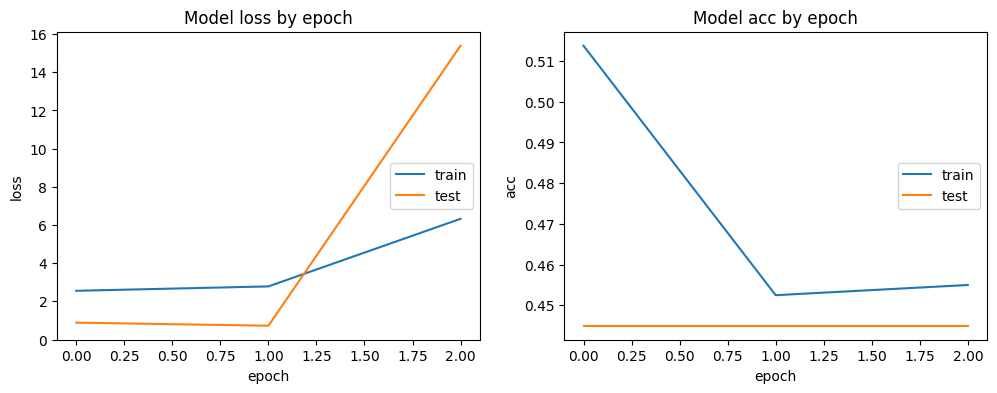

In [18]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

**7. ENREGISTREMENT DU MODELE**

In [50]:
joblib.dump(model, '8. Camembert.pkl')

['8. Camembert.pkl']